In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlinedatasciencechallenge/sample_submission.csv
/kaggle/input/onlinedatasciencechallenge/test_input.csv
/kaggle/input/onlinedatasciencechallenge/train.csv


In [2]:
!pip install feature-engine

     |████████████████████████████████| 152 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor,XGBRegressor,plot_importance,plot_tree
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,GridSearchCV
from pdpbox import pdp, get_dataset, info_plots
import shap
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import lightgbm as lgb
from lightgbm import plot_importance,plot_tree,plot_split_value_histogram
import missingno as msno
from sklearn.pipeline import Pipeline

In [138]:
train=pd.read_csv("/kaggle/input/onlinedatasciencechallenge/train.csv")
test=pd.read_csv("/kaggle/input/onlinedatasciencechallenge/test_input.csv")
submission=pd.read_csv("/kaggle/input/onlinedatasciencechallenge/sample_submission.csv")

In [139]:
submission.head()

,Id,Predicted
0,13.0,0
1,18.0,0
2,106.0,0
3,120.0,0
4,150.0,0


In [140]:
train.shape,test.shape,submission.shape

((173589, 40), (16978, 38), (16978, 2))

In [141]:
train.head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN
1,22234.0,2018-10-31,0,50477.0,122.0,100.0,NaN,100.0,107,258,126,36,2,NaN,2674.0,635.0,NaN,12886.0,17740.0,124.0,2684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,328.0,298.0,298.0,298.0,100,328,467,102,2704,NaN,NaN
2,19974.0,2018-11-30,0,1461.0,1593.0,108.0,2268.0,203.0,117,779,328,37,2,NaN,2678.0,1536.0,16618.0,12707.0,2331.0,884.0,2750,268.0,268.0,436.0,0.0,604.0,0.0,0.0,0.0,436.0,268.0,556.0,0.0,101,268,256,104,2620,NaN,NaN
3,148625.0,2018-03-31,0,9723.0,111.0,100.0,7173.0,100.0,123,316,164,58,3,NaN,2679.0,-2360.0,NaN,3974.0,NaN,118.0,2693,328.0,0.0,496.0,298.0,298.0,298.0,0.0,496.0,298.0,298.0,298.0,298.0,100,328,297,102,2884,NaN,NaN
4,46344.0,2018-11-30,0,2124.0,NaN,100.0,2498.0,NaN,100,129,356,36,2,NaN,2679.0,9.0,683.0,13085.0,NaN,953.0,2808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,268,785,106,2104,NaN,NaN


In [142]:
test.head()

,CUSTNBR,TRAN_DATE,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12
0,65668.0,31.12.2018,579.0,NaN,102.0,418.0,524.0,104,556,227,58,2,NaN,1259.0,1128.0,1900.0,4084.0,5460.0,507.0,1258,0.0,0.0,0.0,0.0,0.0,328.0,328.0,328.0,328.0,298.0,0.0,100,328,124,102,1438,NaN,NaN
1,27913.0,31.12.2018,518.0,980.0,100.0,1239.0,NaN,100,443,284,34,2,NaN,1263.0,737.0,NaN,14016.0,NaN,788.0,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,340,143,106,256,NaN,NaN
2,210.0,31.12.2018,2441.0,4631.0,100.0,1832.0,NaN,101,930,309,34,2,NaN,1276.0,NaN,NaN,13884.0,NaN,239.0,752,0.0,0.0,328.0,328.0,328.0,328.0,0.0,0.0,0.0,0.0,0.0,100,328,47,101,1012,NaN,NaN
3,20674.0,31.12.2018,848.0,504.0,100.0,693.0,NaN,100,101,100,43,2,NaN,1289.0,280.0,NaN,10010.0,NaN,400.0,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,340,237,106,1042,NaN,NaN
4,9822.0,31.12.2018,1709.0,154.0,100.0,760.0,100.0,101,222,125,32,2,NaN,1292.0,5.0,NaN,14837.0,NaN,381.0,1229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,268,338,105,1012,NaN,NaN


In [143]:
train.TRAN_DATE=pd.to_datetime(train.TRAN_DATE)
test.TRAN_DATE=pd.to_datetime(test.TRAN_DATE)

In [144]:
train=train.sort_values(by="TRAN_DATE")

In [145]:
train.TRAN_DATE.min(),train.TRAN_DATE.max()

(Timestamp('2018-03-31 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [146]:
test.TRAN_DATE.min(),test.TRAN_DATE.max()

(Timestamp('2018-12-31 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [147]:
stats.describe(train.ADDCONTAMNT)

DescribeResult(nobs=173589, minmax=(0, 1260100), mean=782.9262510873385, variance=62564117.79419009, skewness=81.11580149821631, kurtosis=10390.252839908888)

In [148]:
train.ADDCONTAMNT.describe([0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).to_frame().T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
ADDCONTAMNT,173589.0,782.926251,7909.748276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1260100.0


In [149]:
train[train.ADDCONTAMNT>0]["ADDCONTAMNT"].describe([0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).to_frame().T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
ADDCONTAMNT,17359.0,7829.217409,23885.139503,400.0,460.0,532.0,700.0,1120.0,1300.0,2200.0,3700.0,6100.0,12100.0,22900.0,1260100.0


In [150]:
nonzero_ADDCONTAMNT=train[train.ADDCONTAMNT>0]["ADDCONTAMNT"]

In [151]:
Q1=nonzero_ADDCONTAMNT.quantile(0.25) 
Q3=nonzero_ADDCONTAMNT.quantile(0.75) 
IQR=Q3-Q1 
lower_limit=Q1-(1.5*IQR) 
upper_limit=Q3+(1.5*IQR) 

In [152]:
nonzero_ADDCONTAMNT[nonzero_ADDCONTAMNT<lower_limit]

Series([], Name: ADDCONTAMNT, dtype: int64)

In [153]:
outlier_indexes=list(nonzero_ADDCONTAMNT[nonzero_ADDCONTAMNT>upper_limit].index)

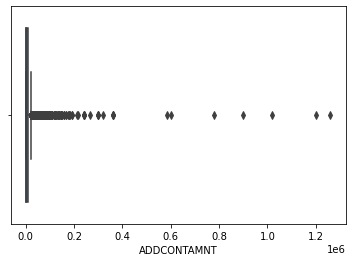

In [154]:
sns.boxplot(train[train.ADDCONTAMNT>0]["ADDCONTAMNT"]);

In [155]:
len(train[train.ADDCONTAMNT.eq(0)])

156230

In [156]:
train.CUSTNBR.nunique(),test.CUSTNBR.nunique()

(155404, 16978)

In [157]:
len(np.setdiff1d(test.CUSTNBR.unique(),train.CUSTNBR.unique())) #testte olup trainde olmayan

13196

In [158]:
len(train.drop_duplicates())

173589

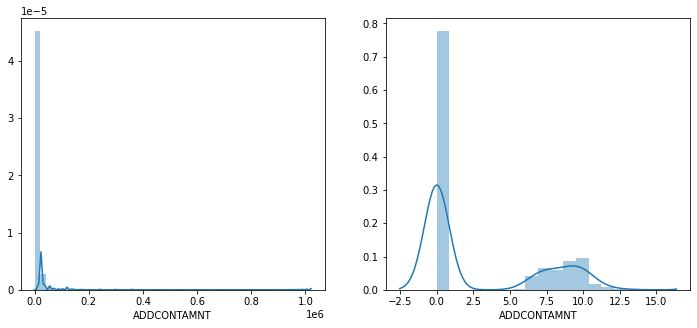

In [159]:
plt.figure(figsize=(12,5));
plt.subplot(121)
sns.distplot(train.dropna().ADDCONTAMNT);
plt.subplot(122)
sns.distplot(np.log1p(train.dropna().ADDCONTAMNT));

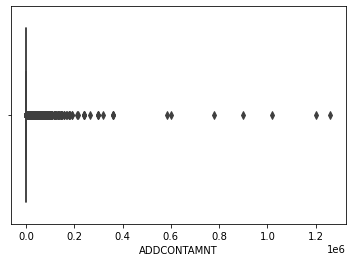

In [160]:
sns.boxplot(train.ADDCONTAMNT);

In [161]:
def see_missings(data):
    missing_frame=pd.DataFrame()
    missing_frame["missing_number"]=data.isnull().sum()
    missing_frame["missing_rate"]=data.isnull().sum()/len(data)
    missing_frame=missing_frame.sort_values(by="missing_rate",ascending=False)

    return missing_frame

def extract_from_date(data):
    data["ay"]=data.TRAN_DATE.dt.month
    data["week"]=data.TRAN_DATE.dt.week   
    data["quarter"]=data.TRAN_DATE.dt.quarter    
    data['semester'] = np.where(data['quarter'].isin([1,2]), 1, 2)


In [162]:
train.head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN
47371,129880.0,2018-03-31,0,7784.0,2516.0,100.0,836.0,934.0,102,816,362,48,1,1241.0,723893.0,334725.0,13840.0,8237.0,NaN,299.0,41043,525.0,525.0,520.0,520.0,520.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,100,525,9580,111,29150,122.0,NaN
47361,163870.0,2018-03-31,24100,110772.0,553258.0,100.0,26127.0,52653.0,106,190,100,70,1,NaN,706004.0,25496.0,612839.0,1247.0,100.0,101.0,230615,2128.0,2128.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,100,2128,63113,110,164392,110.0,698932.0
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN
47355,126394.0,2018-03-31,0,8464.0,14675.0,100.0,18058.0,14074.0,100,160,116,67,1,NaN,691588.0,135874.0,184558.0,120.0,NaN,122.0,364313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,426,131002,114,23847,102.0,185522.0


In [163]:
extract_from_date(train)
extract_from_date(test)

In [164]:
[var for var in train.columns if train[var].isnull().sum() > 0]

['ACCMVMTAVG',
 'ACCAMNTAVG03',
 'ACCACVNUM12',
 'ACCAMNTAVG12',
 'CARDDINSUM12',
 'BLNAMNT03',
 'CRRASTALL',
 'ASTAVGDIF0312',
 'EFTAMNTSUM12',
 'MAXMATEVR',
 'DEBTAVG00',
 'LSTPRDCNUM',
 'CONTPAIDAMNT00',
 'CONTPAIDAMNT01',
 'CONTPAIDAMNT02',
 'CONTPAIDAMNT03',
 'CONTPAIDAMNT04',
 'CONTPAIDAMNT05',
 'CONTPAIDAMNT06',
 'CONTPAIDAMNT07',
 'CONTPAIDAMNT08',
 'CONTPAIDAMNT09',
 'CONTPAIDAMNT10',
 'CONTPAIDAMNT11',
 'LASTAUTOPAYTIME',
 'TIMEDEPAVG12']

In [165]:
miss_frame_train=see_missings(train)
miss_frame_test=see_missings(test)

In [166]:
miss_frame_test

,missing_number,missing_rate
BLNAMNT03,15478,0.911650
TIMEDEPAVG12,13441,0.791672
LASTAUTOPAYTIME,10547,0.621216
EFTAMNTSUM12,8843,0.520851
DEBTAVG00,8602,0.506656
CARDDINSUM12,4952,0.291672
CONTPAIDAMNT03,4623,0.272294
CONTPAIDAMNT04,4623,0.272294
CONTPAIDAMNT05,4623,0.272294
CONTPAIDAMNT06,4623,0.272294


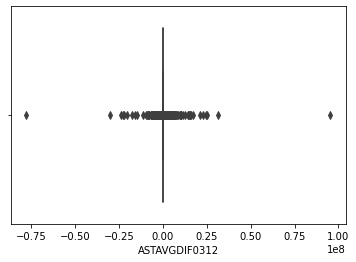

In [167]:
sns.boxplot(train.ASTAVGDIF0312);

In [168]:
train["ASTAVGDIF0312"].mean(),train["ASTAVGDIF0312"].median()

(10891.650389811342, 808.0)

In [169]:
train[train["ASTAVGDIF0312"]<0].shape

(36552, 44)

In [170]:
train["ASTAVG_is_positive"]=np.where(train["ASTAVGDIF0312"]<0,0,1)
test["ASTAVG_is_positive"]=np.where(test["ASTAVGDIF0312"]<0,0,1)

In [171]:
train.head(7)

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN,3,13,1,1,1
47371,129880.0,2018-03-31,0,7784.0,2516.0,100.0,836.0,934.0,102,816,362,48,1,1241.0,723893.0,334725.0,13840.0,8237.0,NaN,299.0,41043,525.0,525.0,520.0,520.0,520.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,100,525,9580,111,29150,122.0,NaN,3,13,1,1,1
47361,163870.0,2018-03-31,24100,110772.0,553258.0,100.0,26127.0,52653.0,106,190,100,70,1,NaN,706004.0,25496.0,612839.0,1247.0,100.0,101.0,230615,2128.0,2128.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,100,2128,63113,110,164392,110.0,698932.0,3,13,1,1,1
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN,3,13,1,1,1
47355,126394.0,2018-03-31,0,8464.0,14675.0,100.0,18058.0,14074.0,100,160,116,67,1,NaN,691588.0,135874.0,184558.0,120.0,NaN,122.0,364313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,426,131002,114,23847,102.0,185522.0,3,13,1,1,1
145603,130777.0,2018-03-31,0,137.0,NaN,101.0,NaN,100.0,116,100,100,51,2,NaN,12747.0,1716.0,NaN,6890.0,334.0,1865.0,13011,0.0,0.0,0.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104,398,3706,110,9242,NaN,NaN,3,13,1,1,1
145605,113325.0,2018-03-31,0,980.0,1434.0,100.0,1614.0,100.0,100,100,100,72,2,NaN,12765.0,-51588.0,NaN,2573.0,100.0,122.0,12920,340.0,340.0,340.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,100,340,1686,106,10936,104.0,81018.0,3,13,1,1,0


In [172]:
train.ASTAVGDIF0312.head()

0            356.0
47371     334725.0
47361      25496.0
145595     10874.0
47355     135874.0
Name: ASTAVGDIF0312, dtype: float64

In [173]:
#train[train["ASTAVGDIF0312"]<0]["ASTAVGDIF0312"]=0

In [174]:
miss_frame_train

,missing_number,missing_rate
BLNAMNT03,157809,0.909096
TIMEDEPAVG12,136748,0.787769
LASTAUTOPAYTIME,107240,0.617781
DEBTAVG00,89082,0.513178
EFTAMNTSUM12,87045,0.501443
CARDDINSUM12,49592,0.285686
CONTPAIDAMNT10,44634,0.257125
CONTPAIDAMNT09,44634,0.257125
CONTPAIDAMNT08,44634,0.257125
CONTPAIDAMNT07,44634,0.257125


In [175]:
col_miss_train=list(miss_frame_train[miss_frame_train.missing_number>0].index)
col_miss_test=list(miss_frame_test[miss_frame_test.missing_number>0].index)

In [176]:
train.CRRASTALL.min(),train.CRRASTALL.max(),train.CRRASTALL.median(),train.CRRASTALL.mean()

(100.0, 158932032.0, 5337.0, 76311.1574571702)

In [177]:
train[train.ADDCONTAMNT>0]["CRRASTALL"].min(),train[train.ADDCONTAMNT>0]["CRRASTALL"].max()

(100.0, 54251868.0)

In [178]:
Q1=train.CRRASTALL.quantile(0.25) 
Q3=train.CRRASTALL.quantile(0.75) 
IQR=Q3-Q1 
lower_limit=Q1-(1.5*IQR) 
upper_limit=Q3+(1.5*IQR) 

In [179]:
lower_limit,upper_limit

(-33109.5, 57462.5)

In [180]:
train[train.CRRASTALL>upper_limit].shape

(24433, 45)

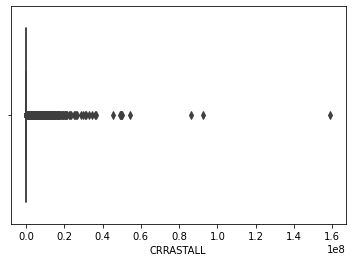

In [181]:
sns.boxplot(train.CRRASTALL);

In [182]:
train[train.CONTPAIDAMNT02==0].shape

(35560, 45)

In [86]:
def impute_na(df, variable, value):

    return df[variable].fillna(value,inplace=True)

In [87]:
col=['CONTPAIDAMNT00', 'CONTPAIDAMNT01',
       'CONTPAIDAMNT02', 'CONTPAIDAMNT03', 'CONTPAIDAMNT04', 'CONTPAIDAMNT05',
       'CONTPAIDAMNT06', 'CONTPAIDAMNT08', 'CONTPAIDAMNT09',
       'CONTPAIDAMNT10', 'CONTPAIDAMNT11']

for i in col:
    impute_na(train,i,0)
for i in col:
    impute_na(test,i,0)

In [183]:
train[train.CONTPAIDAMNT10==0].head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN,3,13,1,1,1
145603,130777.0,2018-03-31,0,137.0,NaN,101.0,NaN,100.0,116,100,100,51,2,NaN,12747.0,1716.0,NaN,6890.0,334.0,1865.0,13011,0.0,0.0,0.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104,398,3706,110,9242,NaN,NaN,3,13,1,1,1
145643,83506.0,2018-03-31,0,4767.0,1142.0,101.0,2639.0,176.0,100,5471,1644,42,2,7482.0,12870.0,3032.0,60652.0,10515.0,190.0,214.0,12706,0.0,0.0,1142.0,0.0,360.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,104,398,2693,107,9759,123.0,NaN,3,13,1,1,1
47273,25527.0,2018-03-31,0,298.0,NaN,100.0,298.0,NaN,100,101,100,53,2,NaN,2034.0,1469.0,NaN,5778.0,NaN,591.0,2284,556.0,298.0,298.0,298.0,0.0,0.0,298.0,298.0,298.0,298.0,0.0,496.0,102,328,236,102,2536,NaN,NaN,3,13,1,1,1
47272,81566.0,2018-03-31,0,40877.0,503.0,100.0,3324.0,NaN,100,179,116,40,4,NaN,2034.0,947.0,59980.0,11630.0,248488.0,744.0,1482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,694.0,0.0,0.0,0.0,100,328,300,102,1630,NaN,NaN,3,13,1,1,1


In [184]:
train[train.LSTPRDCNUM==0]

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive


In [185]:
train.isnull().sum()

CUSTNBR                    0
TRAN_DATE                  0
ADDCONTAMNT                0
ACCMVMTAVG             33109
ACCAMNTAVG03           35080
ACCACVNUM12            19012
ACCAMNTAVG12           41366
CARDDINSUM12           49592
DISTNUM12                  0
INTPHNNUM03                0
INTLOGNUM12                0
DEMINFO1                   0
DEMINFO2                   0
BLNAMNT03             157809
CRRASTALL               1104
ASTAVGDIF0312           5559
EFTAMNTSUM12           87045
MAXMATEVR               8293
DEBTAVG00              89082
LSTPRDCNUM               485
DESACCUAMNT                0
CONTPAIDAMNT00         44634
CONTPAIDAMNT01         44634
CONTPAIDAMNT02         44634
CONTPAIDAMNT03         44634
CONTPAIDAMNT04         44634
CONTPAIDAMNT05         44634
CONTPAIDAMNT06         44634
CONTPAIDAMNT07         44634
CONTPAIDAMNT08         44634
CONTPAIDAMNT09         44634
CONTPAIDAMNT10         44634
CONTPAIDAMNT11         44634
CONTDEBTNUM                0
CONTMONTHAMNT 

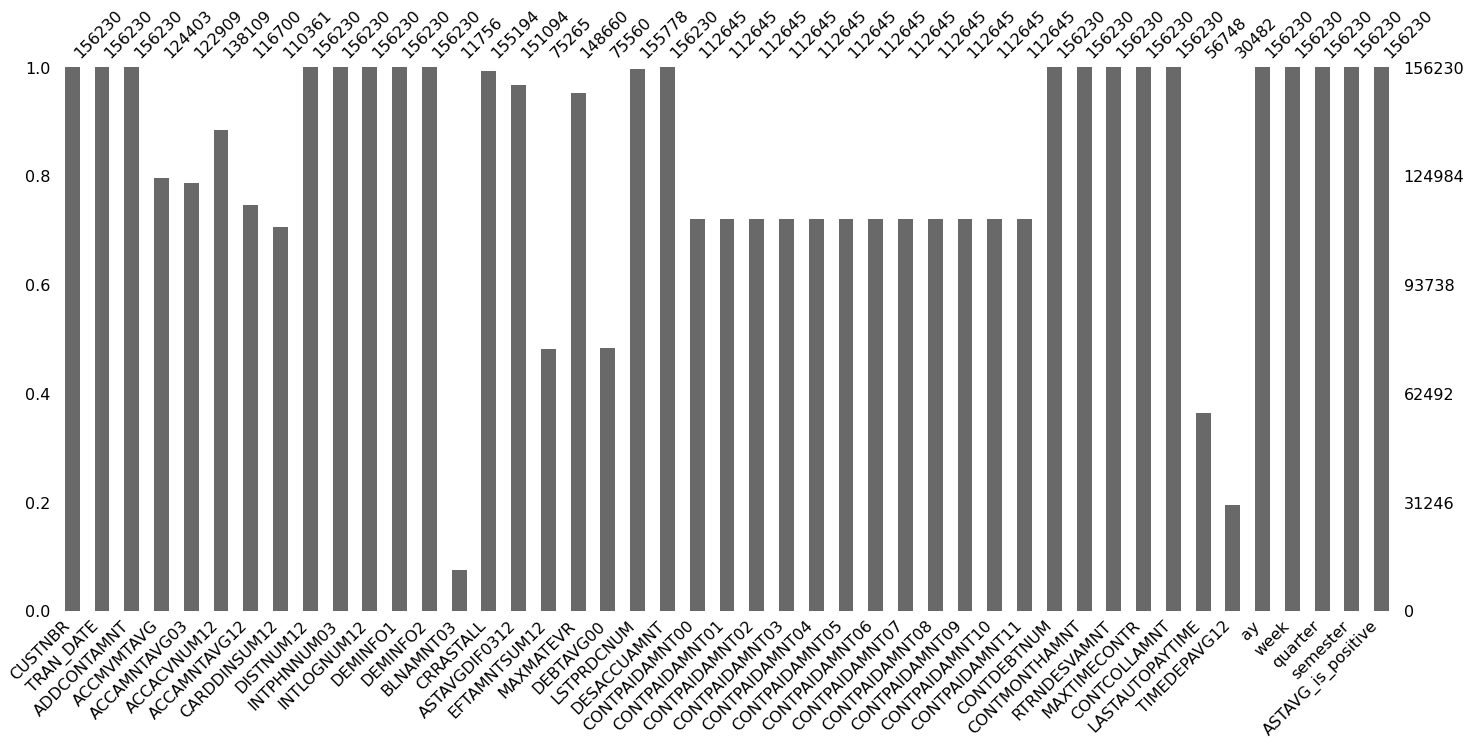

In [186]:
msno.bar(train[train.ADDCONTAMNT==0]);

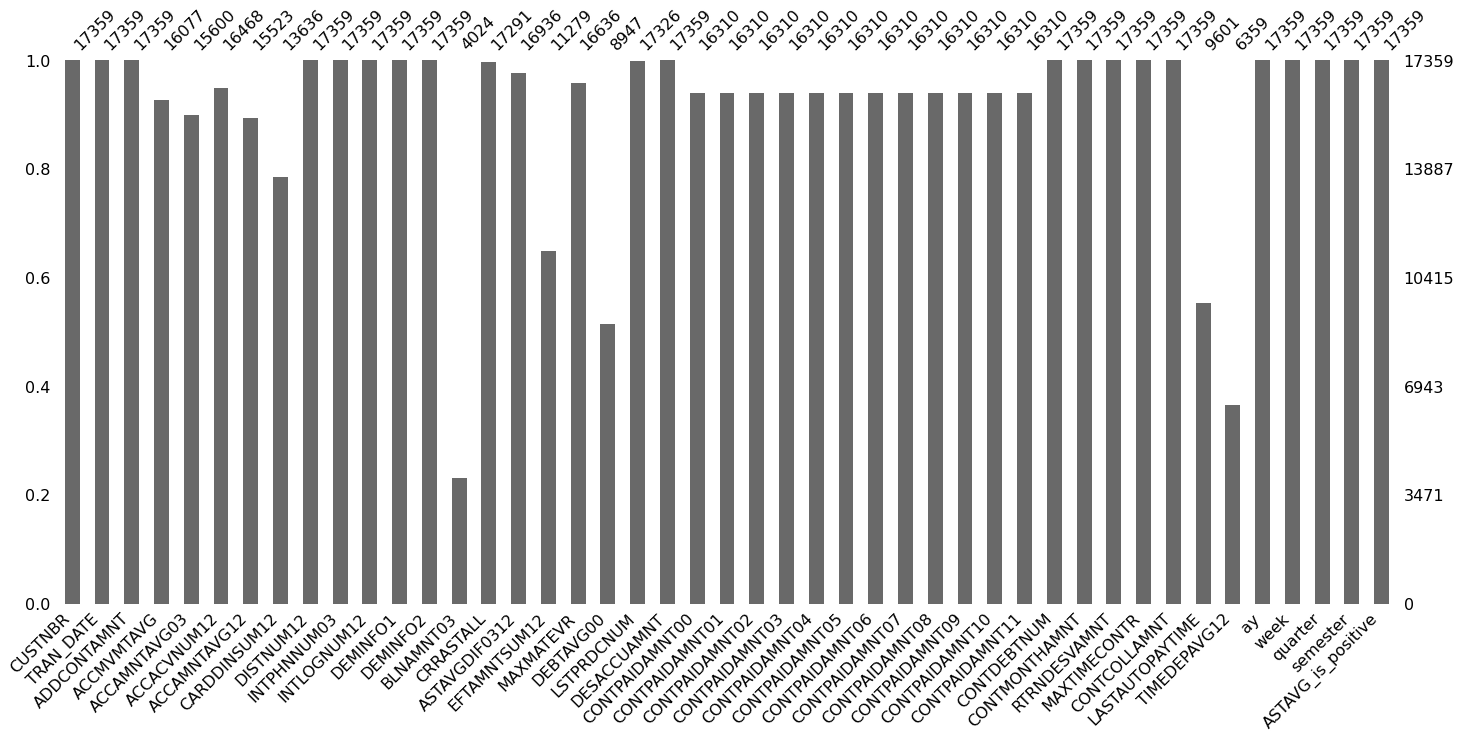

In [187]:
msno.bar(train[train.ADDCONTAMNT>0]);

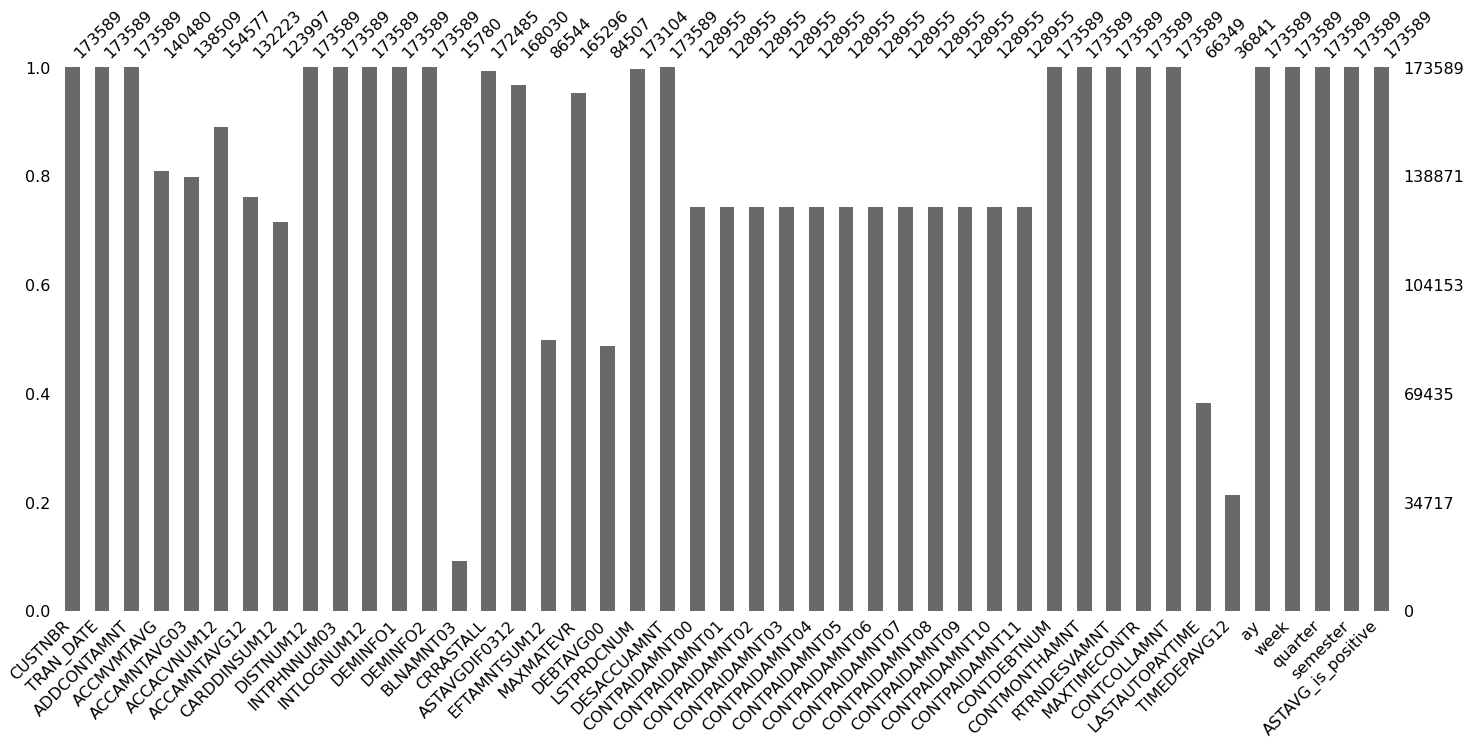

In [188]:
msno.bar(train);

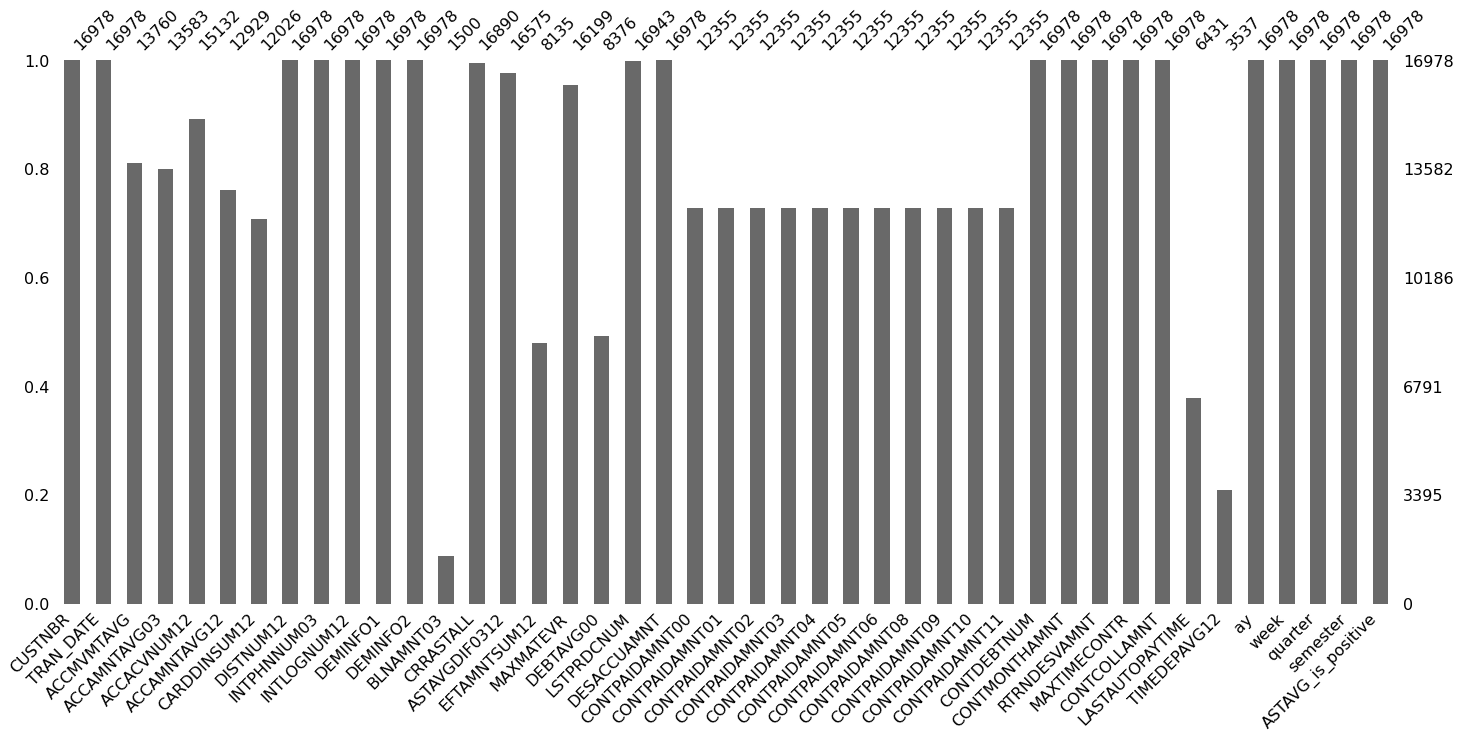

In [189]:
msno.bar(test);

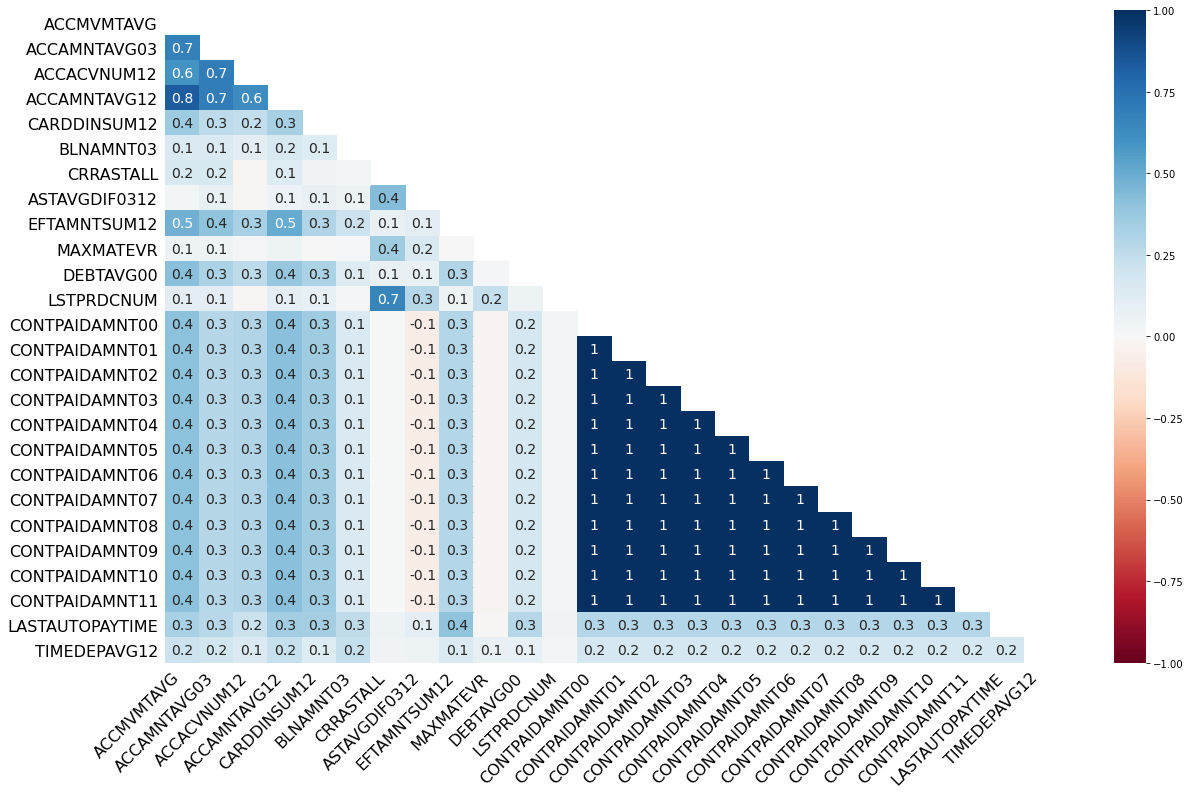

In [190]:
msno.heatmap(train);

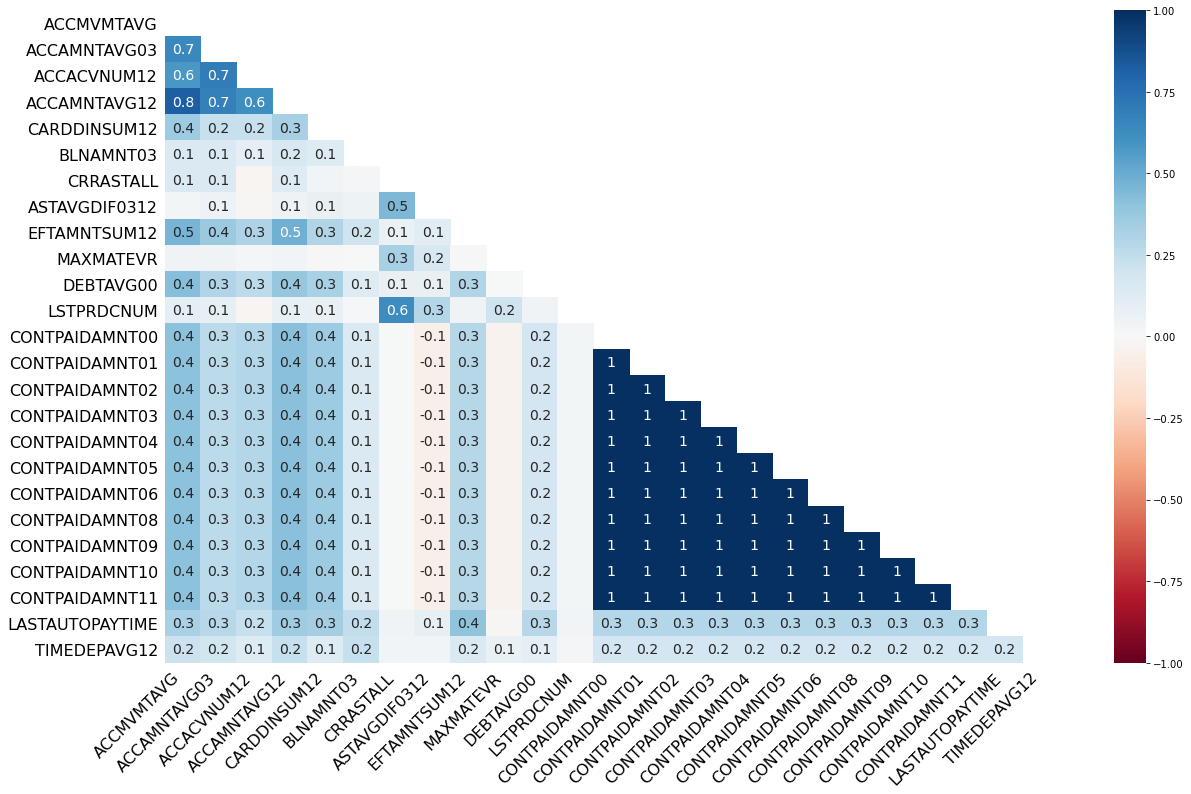

In [191]:
msno.heatmap(test);

In [192]:
train.corr().abs()["ADDCONTAMNT"].nlargest(10).to_frame().T

,ADDCONTAMNT,BLNAMNT03,DESACCUAMNT,RTRNDESVAMNT,CONTCOLLAMNT,CRRASTALL,CONTMONTHAMNT,CONTPAIDAMNT07,TIMEDEPAVG12,CONTPAIDAMNT06
ADDCONTAMNT,1.0,0.344286,0.309601,0.269136,0.206315,0.198337,0.182242,0.156256,0.155007,0.149876


In [193]:
train["TOTAL_CONTPAIDAMNT"]=train["CONTPAIDAMNT00"]+train["CONTPAIDAMNT01"]+train["CONTPAIDAMNT02"]+train["CONTPAIDAMNT03"]+train["CONTPAIDAMNT04"]+train["CONTPAIDAMNT05"]+train["CONTPAIDAMNT06"]+train["CONTPAIDAMNT08"]+train["CONTPAIDAMNT09"]+train["CONTPAIDAMNT10"]+train["CONTPAIDAMNT11"]
test["TOTAL_CONTPAIDAMNT"]=test["CONTPAIDAMNT00"]+test["CONTPAIDAMNT01"]+test["CONTPAIDAMNT02"]+test["CONTPAIDAMNT03"]+test["CONTPAIDAMNT04"]+test["CONTPAIDAMNT05"]+test["CONTPAIDAMNT06"]+test["CONTPAIDAMNT08"]+test["CONTPAIDAMNT09"]+test["CONTPAIDAMNT10"]+test["CONTPAIDAMNT11"]


In [194]:
col=["CONTPAIDAMNT00","CONTPAIDAMNT01","CONTPAIDAMNT02","CONTPAIDAMNT03","CONTPAIDAMNT04",
     "CONTPAIDAMNT05","CONTPAIDAMNT06","CONTPAIDAMNT08","CONTPAIDAMNT09",
     "CONTPAIDAMNT10","CONTPAIDAMNT11"]

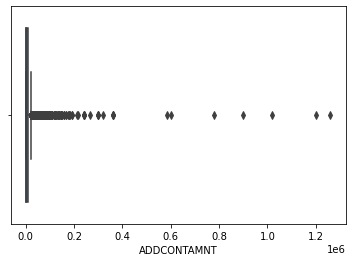

In [195]:
sns.boxplot(train[train.ADDCONTAMNT>0]["ADDCONTAMNT"]);

In [196]:
train[train.ACCACVNUM12==0]["ADDCONTAMNT"].mean(),train[train.ACCACVNUM12==0]["ADDCONTAMNT"].median()

(296.2673082366261, 0.0)

In [197]:
train[train.ACCACVNUM12==0]["ADDCONTAMNT"].max()

57100

In [198]:
train[train.ACCACVNUM12!=0]["ADDCONTAMNT"].mean()

838.0609976655294

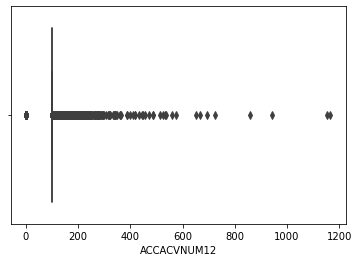

In [199]:
sns.boxplot(train.ACCACVNUM12);

In [200]:
train.head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive,TOTAL_CONTPAIDAMNT
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN,3,13,1,1,1,1690.0
47371,129880.0,2018-03-31,0,7784.0,2516.0,100.0,836.0,934.0,102,816,362,48,1,1241.0,723893.0,334725.0,13840.0,8237.0,NaN,299.0,41043,525.0,525.0,520.0,520.0,520.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,100,525,9580,111,29150,122.0,NaN,3,13,1,1,1,5556.0
47361,163870.0,2018-03-31,24100,110772.0,553258.0,100.0,26127.0,52653.0,106,190,100,70,1,NaN,706004.0,25496.0,612839.0,1247.0,100.0,101.0,230615,2128.0,2128.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,100,2128,63113,110,164392,110.0,698932.0,3,13,1,1,1,23138.0
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN,3,13,1,1,1,3600.0
47355,126394.0,2018-03-31,0,8464.0,14675.0,100.0,18058.0,14074.0,100,160,116,67,1,NaN,691588.0,135874.0,184558.0,120.0,NaN,122.0,364313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,426,131002,114,23847,102.0,185522.0,3,13,1,1,1,NaN


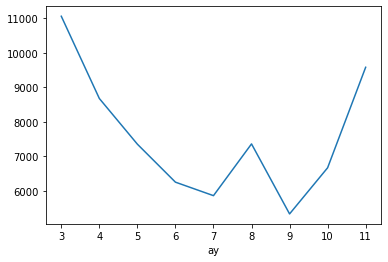

In [201]:
train[train.ADDCONTAMNT>0].groupby("ay")["ADDCONTAMNT"].mean().plot();

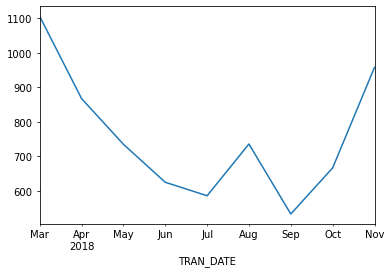

In [202]:
train.groupby(["TRAN_DATE"])["ADDCONTAMNT"].mean().plot();

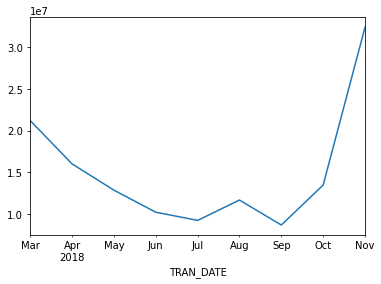

In [203]:
train.groupby(["TRAN_DATE"])["ADDCONTAMNT"].sum().plot();

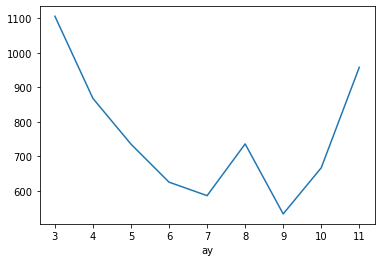

In [204]:
train.groupby("ay")["ADDCONTAMNT"].mean().plot();

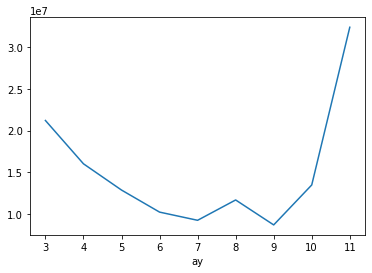

In [205]:
train.groupby("ay")["ADDCONTAMNT"].sum().plot();

In [206]:
test.head()

,CUSTNBR,TRAN_DATE,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive,TOTAL_CONTPAIDAMNT
0,65668.0,2018-12-31,579.0,NaN,102.0,418.0,524.0,104,556,227,58,2,NaN,1259.0,1128.0,1900.0,4084.0,5460.0,507.0,1258,0.0,0.0,0.0,0.0,0.0,328.0,328.0,328.0,328.0,298.0,0.0,100,328,124,102,1438,NaN,NaN,12,1,4,2,1,1610.0
1,27913.0,2018-12-31,518.0,980.0,100.0,1239.0,NaN,100,443,284,34,2,NaN,1263.0,737.0,NaN,14016.0,NaN,788.0,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,340,143,106,256,NaN,NaN,12,1,4,2,1,NaN
2,210.0,2018-12-31,2441.0,4631.0,100.0,1832.0,NaN,101,930,309,34,2,NaN,1276.0,NaN,NaN,13884.0,NaN,239.0,752,0.0,0.0,328.0,328.0,328.0,328.0,0.0,0.0,0.0,0.0,0.0,100,328,47,101,1012,NaN,NaN,12,1,4,2,1,1312.0
3,20674.0,2018-12-31,848.0,504.0,100.0,693.0,NaN,100,101,100,43,2,NaN,1289.0,280.0,NaN,10010.0,NaN,400.0,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,340,237,106,1042,NaN,NaN,12,1,4,2,1,NaN
4,9822.0,2018-12-31,1709.0,154.0,100.0,760.0,100.0,101,222,125,32,2,NaN,1292.0,5.0,NaN,14837.0,NaN,381.0,1229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104,268,338,105,1012,NaN,NaN,12,1,4,2,1,NaN


In [207]:
train.DEMINFO2.value_counts().head()

2    124342
1     18893
3     17740
4     11506
6       586
Name: DEMINFO2, dtype: int64

In [208]:
count_map_=train.CUSTNBR.value_counts().to_dict()
train["count_customer"]=train.CUSTNBR.map(count_map_)
test["count_customer"]=test.CUSTNBR.map(count_map_)

In [209]:
train.head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive,TOTAL_CONTPAIDAMNT,count_customer
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN,3,13,1,1,1,1690.0,1
47371,129880.0,2018-03-31,0,7784.0,2516.0,100.0,836.0,934.0,102,816,362,48,1,1241.0,723893.0,334725.0,13840.0,8237.0,NaN,299.0,41043,525.0,525.0,520.0,520.0,520.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,100,525,9580,111,29150,122.0,NaN,3,13,1,1,1,5556.0,1
47361,163870.0,2018-03-31,24100,110772.0,553258.0,100.0,26127.0,52653.0,106,190,100,70,1,NaN,706004.0,25496.0,612839.0,1247.0,100.0,101.0,230615,2128.0,2128.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,100,2128,63113,110,164392,110.0,698932.0,3,13,1,1,1,23138.0,1
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN,3,13,1,1,1,3600.0,1
47355,126394.0,2018-03-31,0,8464.0,14675.0,100.0,18058.0,14074.0,100,160,116,67,1,NaN,691588.0,135874.0,184558.0,120.0,NaN,122.0,364313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,426,131002,114,23847,102.0,185522.0,3,13,1,1,1,NaN,1


In [210]:
train.isnull().sum().sum(),test.isnull().sum().sum()

(1351766, 144348)

In [211]:
train.shape,test.shape

((173589, 47), (16978, 45))

In [212]:
train.head()

,CUSTNBR,TRAN_DATE,ADDCONTAMNT,ACCMVMTAVG,ACCAMNTAVG03,ACCACVNUM12,ACCAMNTAVG12,CARDDINSUM12,DISTNUM12,INTPHNNUM03,INTLOGNUM12,DEMINFO1,DEMINFO2,BLNAMNT03,CRRASTALL,ASTAVGDIF0312,EFTAMNTSUM12,MAXMATEVR,DEBTAVG00,LSTPRDCNUM,DESACCUAMNT,CONTPAIDAMNT00,CONTPAIDAMNT01,CONTPAIDAMNT02,CONTPAIDAMNT03,CONTPAIDAMNT04,CONTPAIDAMNT05,CONTPAIDAMNT06,CONTPAIDAMNT07,CONTPAIDAMNT08,CONTPAIDAMNT09,CONTPAIDAMNT10,CONTPAIDAMNT11,CONTDEBTNUM,CONTMONTHAMNT,RTRNDESVAMNT,MAXTIMECONTR,CONTCOLLAMNT,LASTAUTOPAYTIME,TIMEDEPAVG12,ay,week,quarter,semester,ASTAVG_is_positive,TOTAL_CONTPAIDAMNT,count_customer
0,22776.0,2018-03-31,0,641.0,NaN,100.0,396.0,204.0,100,100,100,57,2,NaN,2673.0,356.0,NaN,3987.0,NaN,1276.0,3098,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,520.0,310.0,0.0,104,340,272,104,2926,NaN,NaN,3,13,1,1,1,1690.0,1
47371,129880.0,2018-03-31,0,7784.0,2516.0,100.0,836.0,934.0,102,816,362,48,1,1241.0,723893.0,334725.0,13840.0,8237.0,NaN,299.0,41043,525.0,525.0,520.0,520.0,520.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,100,525,9580,111,29150,122.0,NaN,3,13,1,1,1,5556.0,1
47361,163870.0,2018-03-31,24100,110772.0,553258.0,100.0,26127.0,52653.0,106,190,100,70,1,NaN,706004.0,25496.0,612839.0,1247.0,100.0,101.0,230615,2128.0,2128.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,2098.0,100,2128,63113,110,164392,110.0,698932.0,3,13,1,1,1,23138.0,1
145595,2573.0,2018-03-31,0,1095.0,9641.0,100.0,400.0,NaN,100,100,100,60,2,NaN,12680.0,10874.0,NaN,4128.0,NaN,454.0,3060,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,0.0,100,400,242,101,3100,NaN,NaN,3,13,1,1,1,3600.0,1
47355,126394.0,2018-03-31,0,8464.0,14675.0,100.0,18058.0,14074.0,100,160,116,67,1,NaN,691588.0,135874.0,184558.0,120.0,NaN,122.0,364313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,426,131002,114,23847,102.0,185522.0,3,13,1,1,1,NaN,1


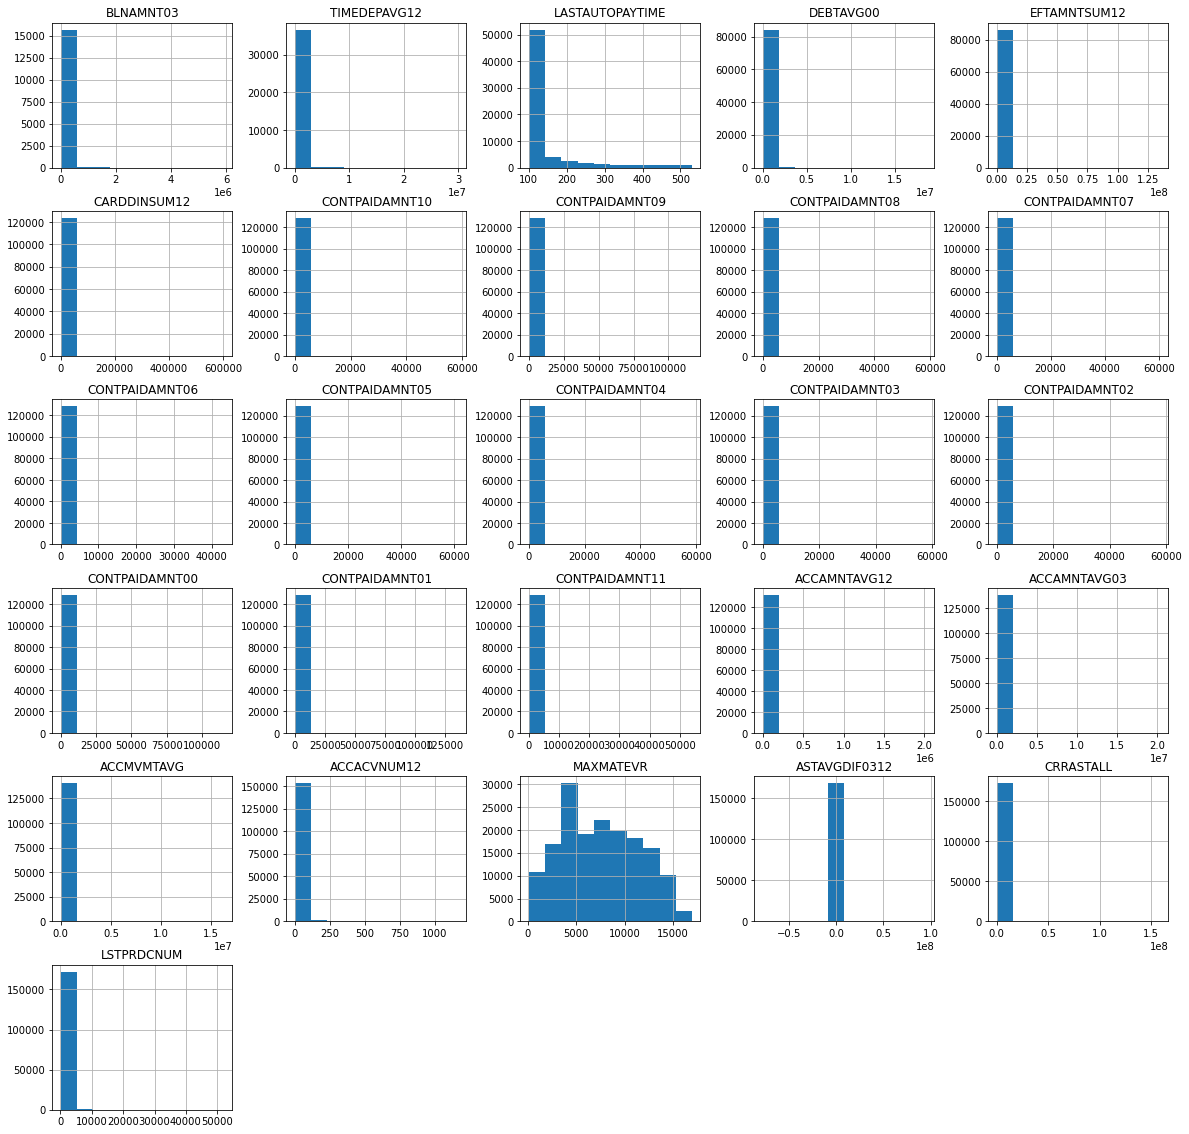

In [213]:
train[col_miss_train].hist(figsize=(20,20));

In [214]:
#mean_add=train.groupby("CUSTNBR")["ADDCONTAMNT"].mean()
#train=pd.merge(train,mean_add,how="inner",on="CUSTNBR").rename({"ADDCONTAMNT_x":"ADDCONTAMNT","ADDCONTAMNT_y":"mean_add"},axis=1)
#test=pd.merge(test,mean_add,how="inner",on="CUSTNBR").rename({"ADDCONTAMNT":"mean_add"},axis=1)

In [215]:
X=train.drop(["TRAN_DATE","ADDCONTAMNT","CONTPAIDAMNT07","CUSTNBR","week","semester"],axis=1)
y=train["ADDCONTAMNT"]
X_train_deneme,X_test_deneme,y_train_deneme,y_test_deneme=train_test_split(X,y,shuffle=False)
X_train_deneme.shape,X_test_deneme.shape,y_train_deneme.shape,y_test_deneme.shape

((130191, 41), (43398, 41), (130191,), (43398,))

In [216]:
#def missing_indicator(df, variable):    
#    return np.where(df[variable].isnull(), 1, 0)

#for variable in col_to_use:
#    X_train[variable+'_NA'] = missing_indicator(X_train, variable)
#    X_test[variable+'_NA'] = missing_indicator(X_test, variable)

In [217]:
scaler=RobustScaler()
X_train_deneme_scaled=scaler.fit_transform(X_train_deneme)
X_test_deneme_scaled=scaler.transform(X_test_deneme)

model=LGBMRegressor(reg_alpha=0.01)
model_fitted=model.fit(X_train_deneme_scaled,y_train_deneme)
pred=model_fitted.predict(X_test_deneme_scaled)

In [218]:
r2_score(y_test_deneme,pred)

-0.4668318385651422

In [219]:
model.score(X_train_deneme_scaled,y_train_deneme)

0.6970536147158837

In [220]:
np.sqrt(mean_squared_error(y_test_deneme,pred))

6876.067426998721

In [221]:
X_train=train.drop(["TRAN_DATE","ADDCONTAMNT","CONTPAIDAMNT07","CUSTNBR","week","semester","ay","TIMEDEPAVG12"],axis=1)
X_test=test.drop(["TRAN_DATE","CUSTNBR","week","semester","ay","TIMEDEPAVG12"],axis=1)
y_train=train["ADDCONTAMNT"]

In [222]:
X_train.shape,X_test.shape,y_train.shape

((173589, 39), (16978, 39), (173589,))

In [223]:
scaler=RobustScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [224]:
X_train_scaled.shape,X_test_scaled.shape

((173589, 39), (16978, 39))

In [225]:
model=LGBMRegressor()
model_fitted=model.fit(X_train_scaled,y_train)
pred=model_fitted.predict(X_test_scaled)

In [226]:
model.score(X_train_scaled,y_train)

0.707870831803399

In [227]:
test_id=test.CUSTNBR

In [228]:
submit=pd.DataFrame()
submit["Id"]=test_id
submit["Predicted_"]=pred
submit.head()

,Id,Predicted_
0,65668.0,56.378096
1,27913.0,65.749363
2,210.0,76.046856
3,20674.0,68.419496
4,9822.0,68.419496


In [229]:
submit.isnull().sum()

Id            0
Predicted_    0
dtype: int64

In [230]:
submission=submission.join(submit.set_index("Id"),on="Id").drop("Predicted",axis=1).rename({"Predicted_":"Predicted"},axis=1)

In [231]:
submission.isnull().sum()

Id           0
Predicted    0
dtype: int64

In [232]:
from IPython.display import FileLink
submission_csv=submission.to_csv("submission.csv",index=False)
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [233]:
def plot_imp(model):
    model.importance_type="split"
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(18,12));
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False));
    plt.title("Feature Importance (Split)")
    plt.show()
   # plot_importance(booster=model,figsize=(20,10),height=0.5,importance_type="gain");
    model.importance_type="gain"
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(18,12));
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False));
    plt.title("Feature Importance (Gain)")
    plt.show()

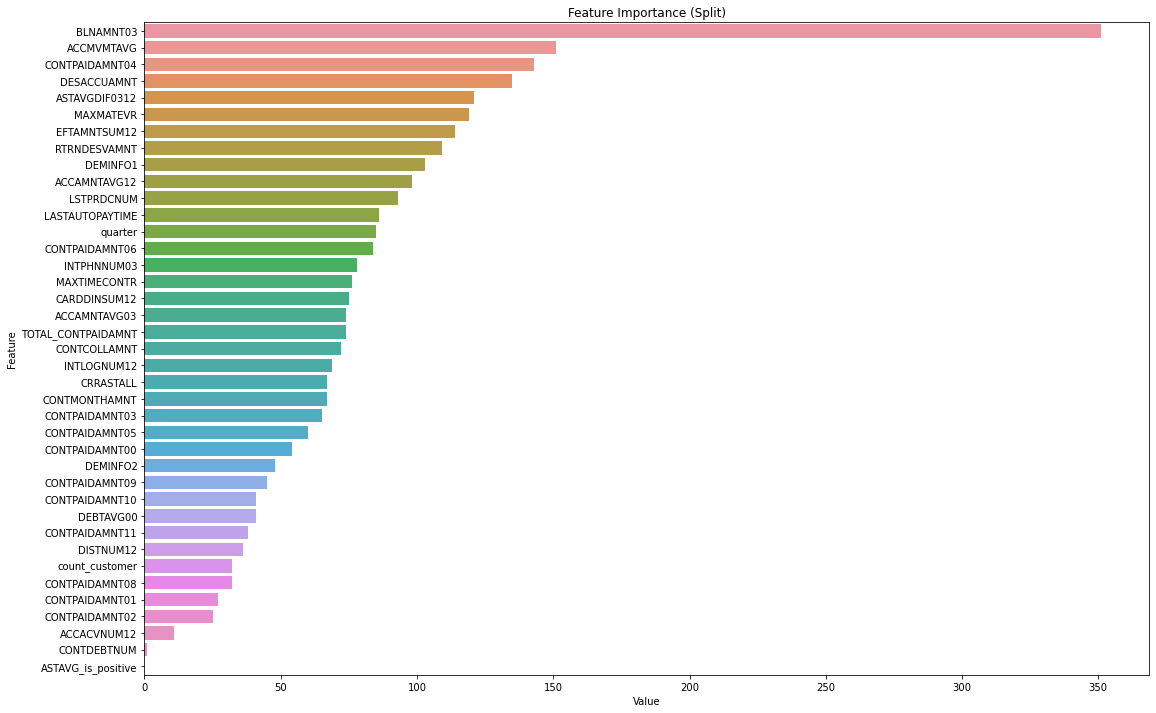

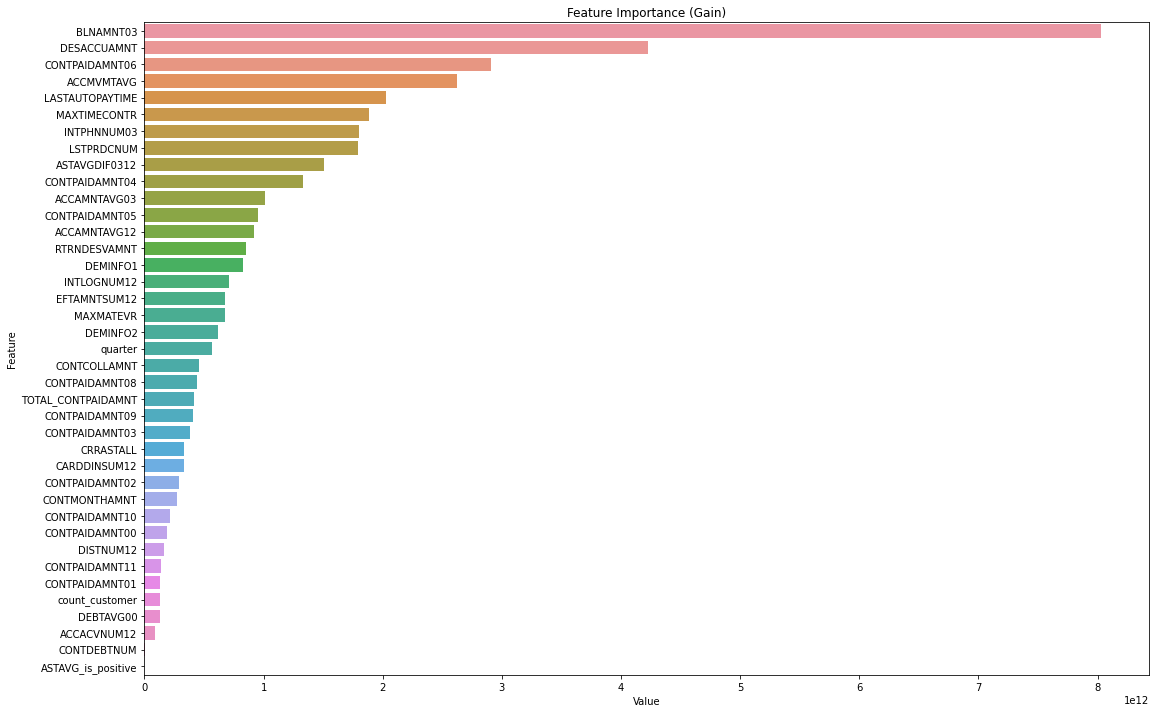

In [234]:
plot_imp(model)

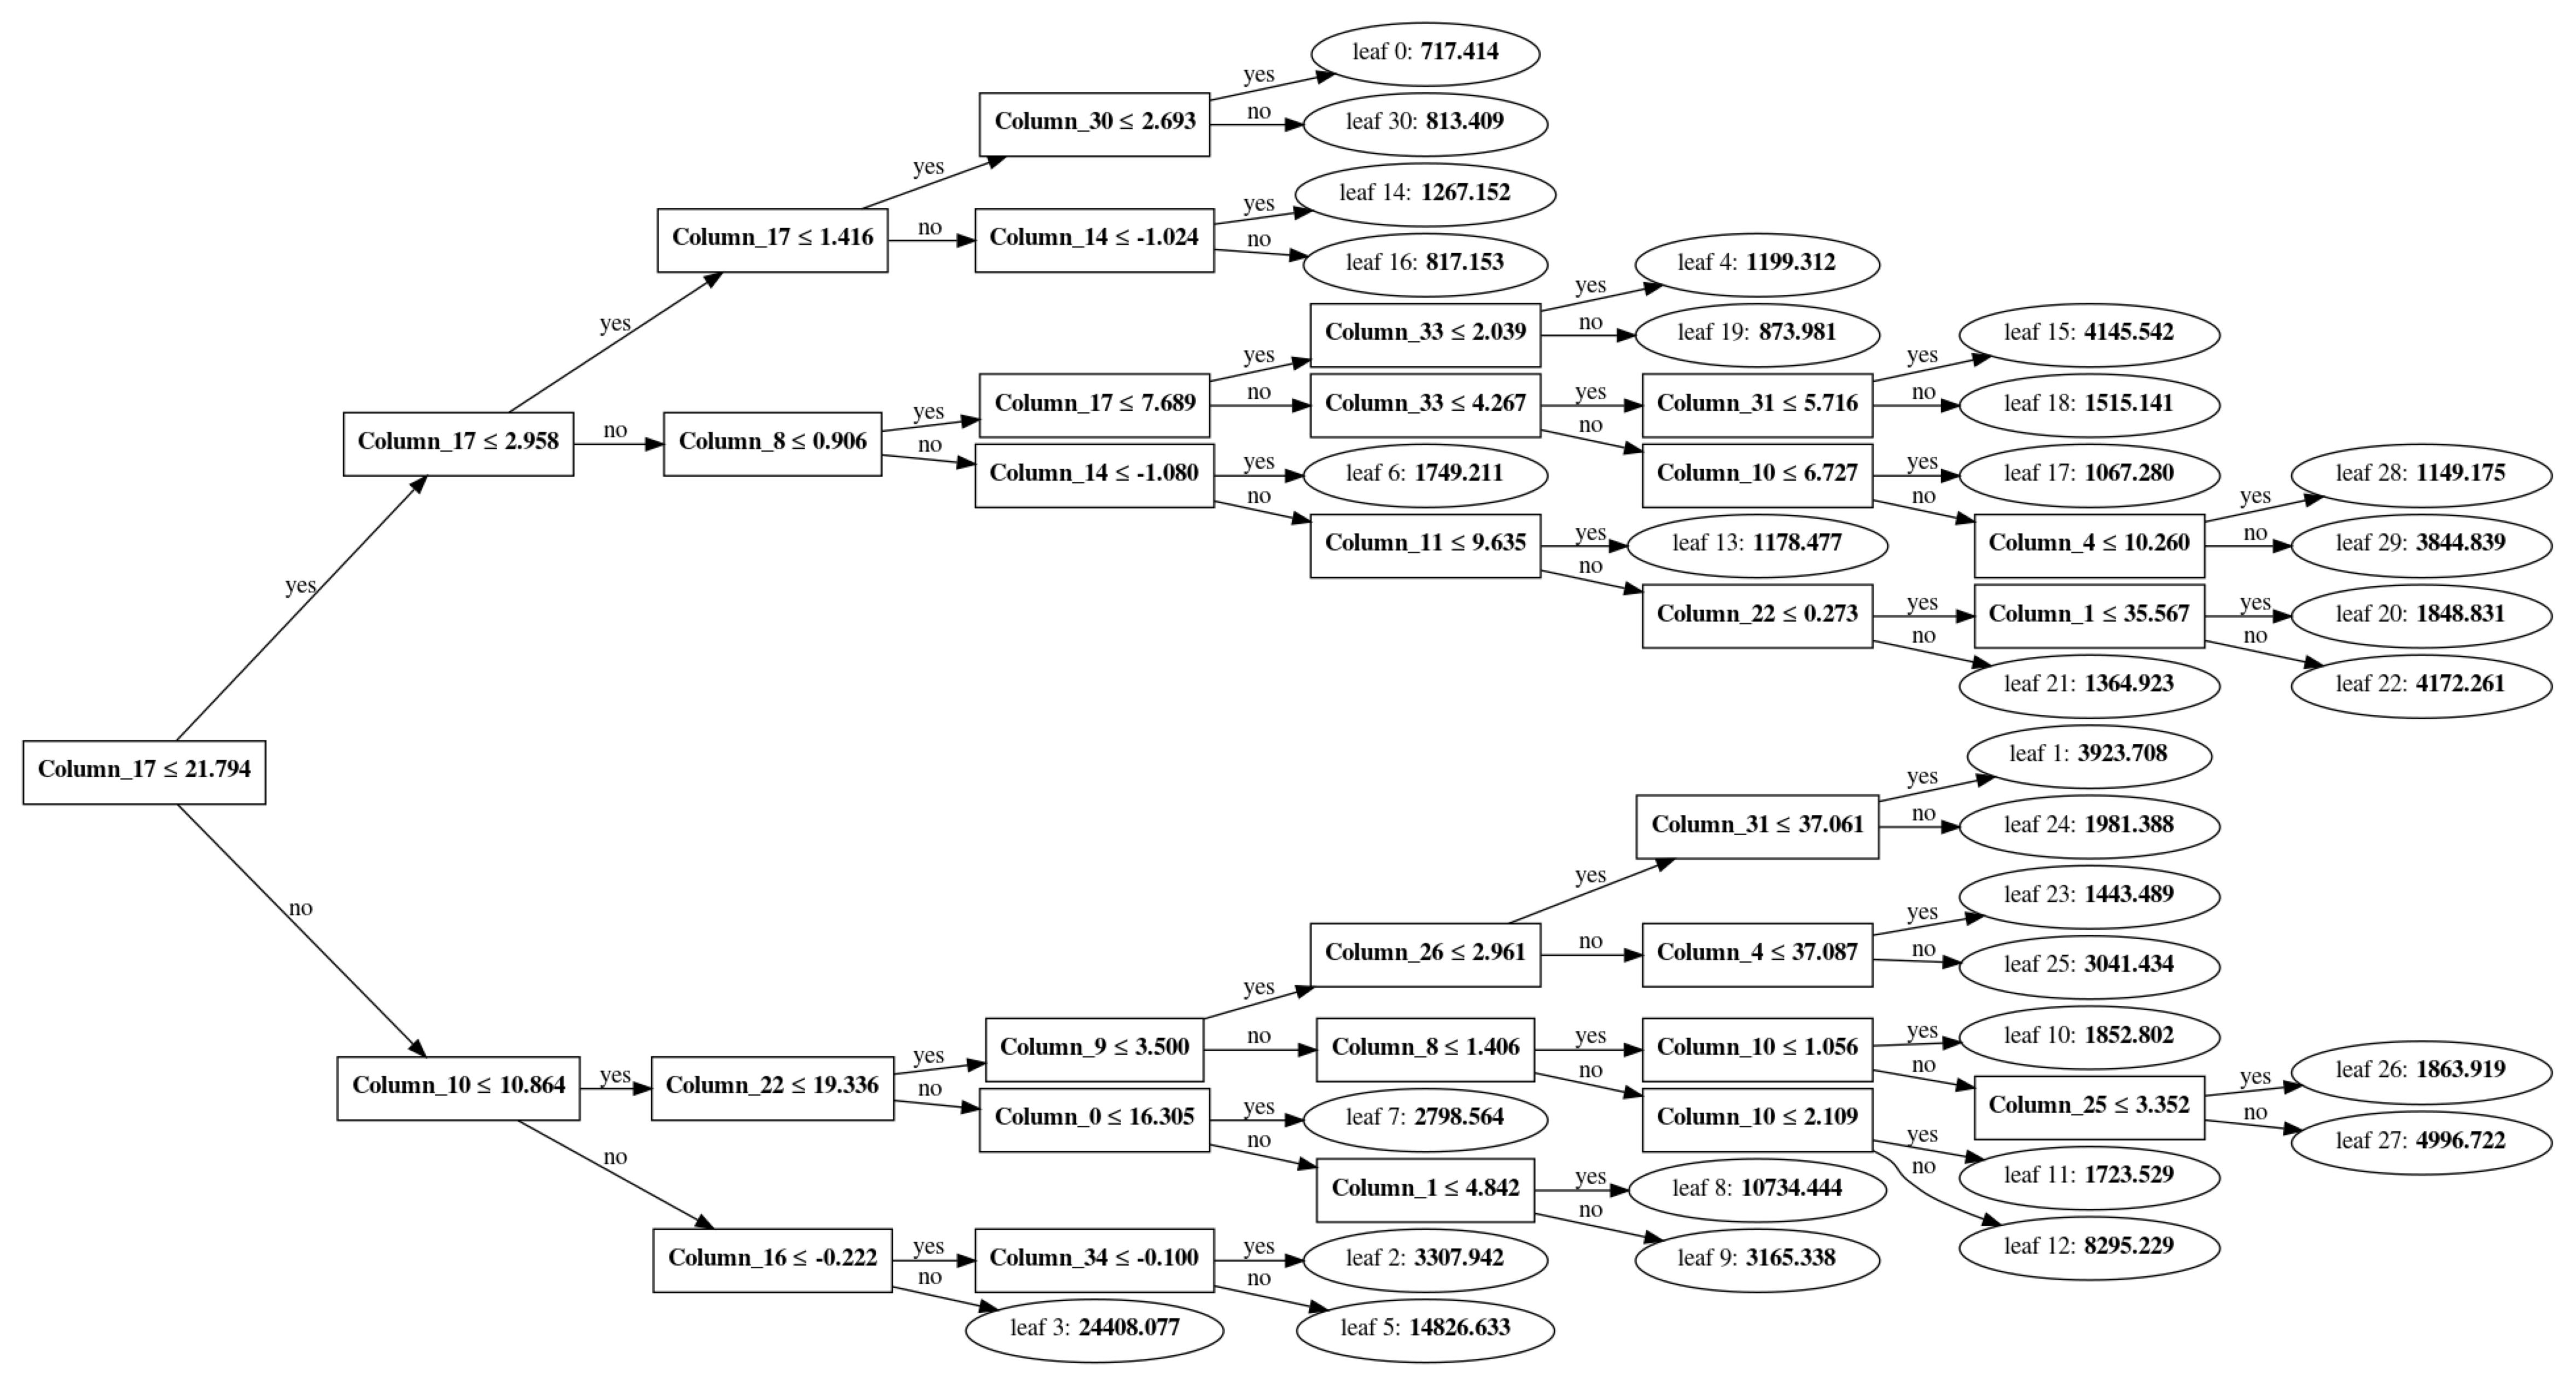

In [235]:
plot_tree(model,figsize=(20,15),dpi=300);